Week 3: Global Optimization

4.2 The potential

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
plt.rc('animation', html='jshtml') #something to do with with jupyter notebooks animation

In [141]:
#N = 50  # number of points
highlighted_dots = 5
Delta = 1  # magnitude of step size
steps = 100  # number of iterations in walk
kT = 1.0  # Temperature for the Metropolis criterion

In [142]:
#defining the potential
def V(x):
    return (-1  -np.exp(-((x+15)/10)**2) \
              -2*np.exp(-((x-10)/10)**2) + \
                -np.exp(-((x-35)/10)**2) \
              -3*np.exp(-((x-60)/10)**2) \
                -np.exp(-((x-85)/10)**2)\
              -2*np.exp(-((x-110)/10)**2) \
              ) * \
            (1+1/5*np.cos(2*np.pi/2.5*x))

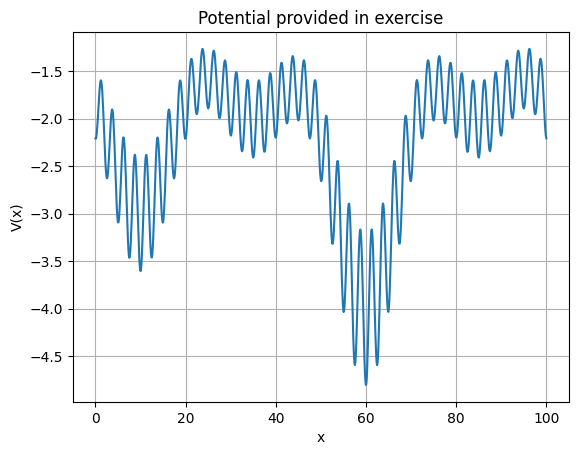

In [143]:
#plotting the potential
def plot_potential():
    x = np.linspace (0,100,1000)
    y = V(x)

    plt.plot(x,y, label='V(x)')
    plt.title('Potential provided in exercise')
    plt.xlabel('x')
    plt.ylabel('V(x)')
    plt.legend
    plt.grid(True)
    plt.show

plot_potential()

4.3 Short trajectories: Metropolis MC to create a Markov chain trajectory at two different temps.

In [144]:
#metropolis sampling function specifically for the given potential in the exercise
print(V(x))
def metropolis_sampling(x0, N, Delta,kT):
    samples = []
    current_x = x0
    for _ in range(N):
        # Propose new x' using random walk: x' = x + delta * N(0,1)
        RNDn = np.random.randn()  # Random distribution "randn"
        proposed_x = current_x + Delta * RNDn

        # Calculate potential energy at current and proposed positions
        current_pot = V(current_x)
        proposed_pot = V(proposed_x)

        # Acceptance probability (min(1, exp(-(V(x') - V(x)) / kT)))
        delta_E = proposed_pot - current_pot
        acceptance_prob = min(1, np.exp(-delta_E / kT)) # RND<exp(-Delta_E/kT)

        # Accept or reject the new position
        if np.random.rand() < acceptance_prob:
            current_x = proposed_x  # Accept the move

        # Store the current position
        samples.append(current_x)

    return np.array(samples)


[-2.20939547 -2.21174038 -2.1914553  -2.15027332 -2.09128153 -2.01874491
 -1.93785365 -1.85440869 -1.77446425 -1.70394927 -1.64829106 -1.61206516
 -1.59869366 -1.61021181 -1.64711877 -1.7083232  -1.79118855 -1.89167692
 -2.0045837  -2.12384981 -2.24293275 -2.35521403 -2.4544176  -2.53501291
 -2.59257674 -2.62409016 -2.62815069 -2.60508484 -2.55695231 -2.48743983
 -2.40164987 -2.30579587 -2.20682214 -2.11197152 -2.02832765 -1.96236071
 -1.9195057  -1.90380079 -1.91760977 -1.96144752 -2.03392131 -2.13179321
 -2.25016145 -2.38275069 -2.52229422 -2.6609846  -2.79096505 -2.90483031
 -2.99610506 -3.05966889 -3.09209971 -3.09191257 -3.0596772  -2.99800513
 -2.91140578 -2.80601906 -2.68924028 -2.56926032 -2.4545496  -2.35331853
 -2.27298887 -2.21971027 -2.19795343 -2.2102071  -2.25679936 -2.33585591
 -2.44339951 -2.57358536 -2.71905855 -2.87141165 -3.02171376 -3.1610776
 -3.28122823 -3.37503691 -3.43698538 -3.46352991 -3.45334118 -3.40740352
 -3.32896609 -3.22334836 -3.09761141 -2.96011542 -2.

In [157]:
#setting up the two chains

MC_time_interval = 9
delta = 1.5
starting_x = 3

# First chain
kT_1 = 0.010
chain_1 = metropolis_sampling(starting_x, MC_time_interval, delta, kT_1)
chain_1 = np.insert(chain_1, 0, starting_x)
MC_steps_1 = np.arange(MC_time_interval + 1)

# Second chain
kT_2 = 100.0
chain_2 = metropolis_sampling(starting_x, MC_time_interval, delta, kT_2)
chain_2 = np.insert(chain_2, 0, starting_x)
MC_steps_2 = np.arange(MC_time_interval + 1)

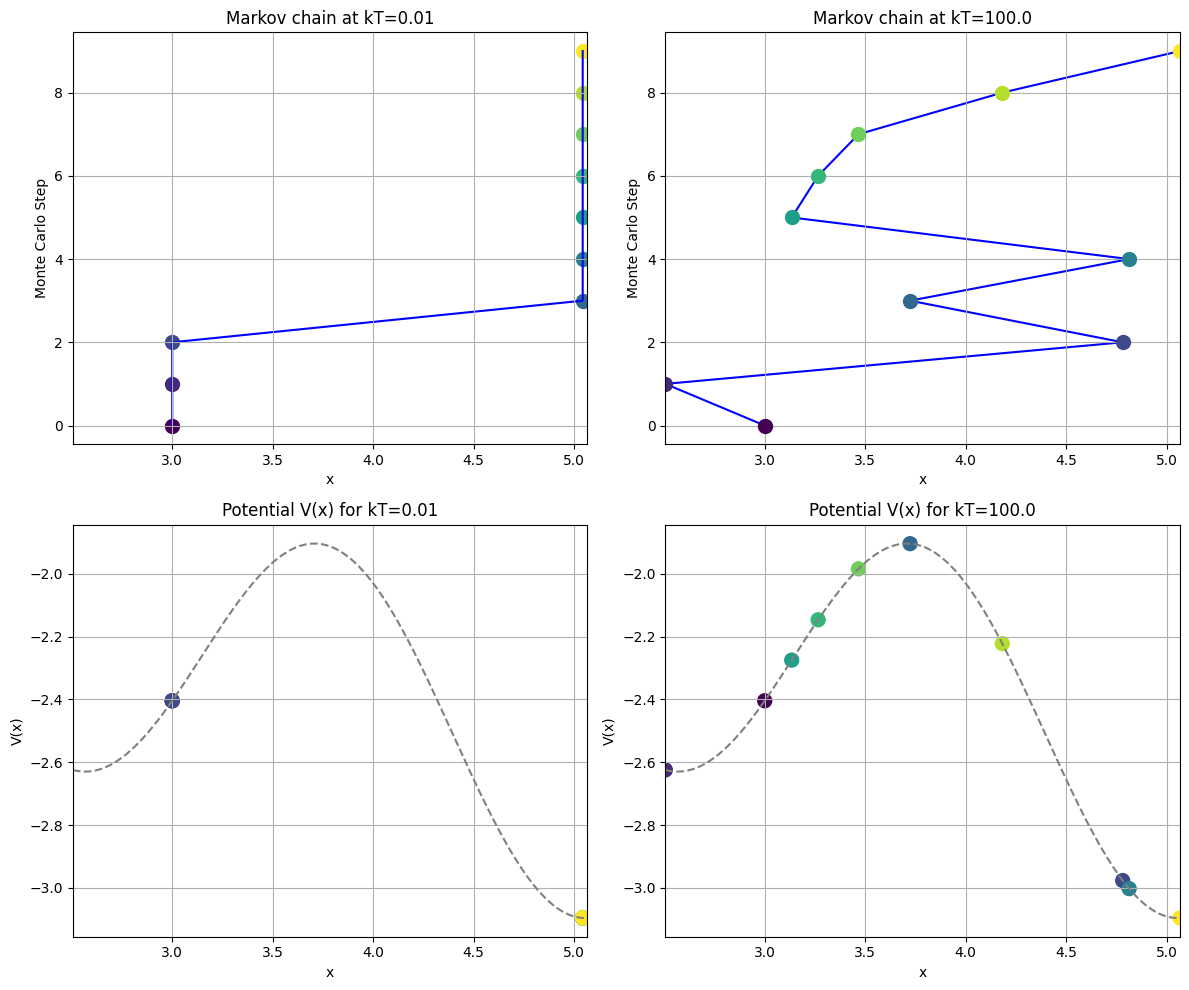

In [158]:
#actually making the 4 plots

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

x_limits = (min(min(chain_1),min(chain_2)), max(max(chain_1),max(chain_2)))
x_range = np.linspace(x_limits[0], x_limits[1], 500)
V_values = V(x_range)

#first plot 
colors_1 = plt.cm.viridis(np.linspace(0, 1, len(chain_1)))
for i in range(len(chain_1)):
    axs[0, 0].scatter(chain_1[i], MC_steps_1[i], color=colors_1[i], s=100, zorder=1)  # Larger points
axs[0, 0].plot(chain_1, MC_steps_1, linestyle='-', color='b', zorder=1)
axs[0, 0].set_title(f'Markov chain at kT={kT_1}')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('Monte Carlo Step')
axs[0, 0].set_xlim(x_limits)
axs[0, 0].grid(True)

#second plot
colors_2 = plt.cm.viridis(np.linspace(0, 1, len(chain_2)))
for i in range(len(chain_2)):
    axs[0, 1].scatter(chain_2[i], MC_steps_2[i], color=colors_2[i], s=100, zorder=2)  # Larger points
axs[0, 1].plot(chain_2, MC_steps_2, linestyle='-', color='b', zorder=1)
axs[0, 1].set_title(f'Markov chain at kT={kT_2}')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('Monte Carlo Step')
axs[0, 1].set_xlim(x_limits)
axs[0, 1].grid(True)

# Plot the potential energy for the first chain in the bottom left
axs[1, 0].plot(x_range, V_values, color='gray', linestyle='--', label='Potential V(x)')
axs[1, 0].scatter(chain_1, V(chain_1), color=colors_1, s=100)  # Superimpose chain_1 points with corresponding colors
axs[1, 0].set_title(f'Potential V(x) for kT={kT_1}')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('V(x)')
axs[1, 0].set_xlim(x_limits)
axs[1, 0].grid(True)

# Plot the potential energy for the second chain in the bottom right
axs[1, 1].plot(x_range, V_values, color='gray', linestyle='--', label='Potential V(x)')
axs[1, 1].scatter(chain_2, V(chain_2), color=colors_2, s=100)  # Superimpose chain_2 points with corresponding colors
axs[1, 1].set_title(f'Potential V(x) for kT={kT_2}')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('V(x)')
axs[1, 1].set_xlim(x_limits)
axs[1, 1].grid(True)


plt.tight_layout()
plt.show()

4.4 Long trajectories:
c) Start one or several low-temperature walkers and observe that they might get stuck in local minima.

In [164]:
# Parameters
MC_time_interval = 50
delta = 1
starting_x = 30
kT = 1000

# Get the chain of x-values and corresponding y-values (V(x))
chain = metropolis_sampling(starting_x, MC_time_interval, delta, kT)
chain = np.insert(chain, 0, starting_x)
xs_1 = chain
ys_1 = V(xs_1)

chain = metropolis_sampling(starting_x, MC_time_interval, delta, kT)
chain = np.insert(chain, 0, starting_x)
xs_2 = chain_2
ys_2 = V(xs_2)

# Combine x and y into points_in_time
points_in_time_1 = list(zip(xs_1, ys_1))
points_in_time_2 = list(zip(xs_2, ys_2))

# Create figure for animation
fig, ax = plt.subplots()

# Plot the static potential V(x)
x_static = np.linspace(0, 100, 1000)
y_static = V(x_static)
ax.plot(x_static, y_static, label="V(x)", color='blue')

# Set limits based on the data
ax.set_xlim(min(x_static), max(x_static))
ax.set_ylim(min(y_static), max(y_static))
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")

scat = ax.scatter([], [], marker='o', color='red')

print(len(points_in_time_1))

# Update function for the animation
def update(frame):
    data_1 = np.array([points_in_time_1[frame]]) 
    scat.set_offsets(data_1)
    data_2 = np.array([points_in_time_2[frame]]) 
    scat.set_offsets(data_2)
    return [scat]

# Create the animation
anim = FuncAnimation(fig, update, frames=MC_time_interval+1, interval=100, blit=True)

plt.close(fig)
HTML(anim.to_jshtml())

51


IndexError: list index out of range